# Informações sobre o modelo

- [X] informações da grade: espaçamento, bounding box, isobaths
- [ ] cenário das estações
- [ ] cenário de maré
- [ ] corrente residual dos cenários de maré

In [1]:
import pooch

url = "https://github.com/LaPoGeoMar/Proj_Modelagem_Pellet/releases/download"
version = "v0.1.0"

fname = pooch.retrieve(
    url=f"{url}/{version}/model_tides_only.nc4",
    known_hash="sha256:b6941a8e4cf158790d899e00e644d6c6a6dcaf28128623467699e5a3b23417cd",
)

## Dataset summary

In [2]:
import xarray as xr

ds = xr.open_dataset(fname)
ds

<xarray.Dataset>
Dimensions:     (m: 138, n: 218, time: 8772)
Coordinates:
    Layer       float32 ...
    latitude    (m, n) float32 ...
    longitude   (m, n) float32 ...
  * m           (m) float32 -48.87 -48.87 -48.86 -48.85 ... -47.53 -47.52 -47.51
  * n           (n) float32 -28.62 -28.62 -28.61 -28.6 ... -26.48 -26.47 -26.47
  * time        (time) datetime64[ns] 2021-01-01 ... 2022-01-01
Data variables:
    velocity_x  (time, m, n) float32 ...
    velocity_y  (time, m, n) float32 ...
    waterlevel  (time, m, n) float32 ...
Attributes: (12/25)
    title:                         NetCDF created from NEFIS-file trim-sc_fl_...
    institution:                   
    source:                        Delft3D trim file
    history:                       Wed Mar 15 14:42:40 2023: ncks -4 -L 1 mod...
    references:                    http://svn.oss.deltares.nl
    email:                         
    ...                            ...
    geospatial_lon_units:          dergees_east
    geospatial_vertical_min:       2.2039968967437744
    geospatial_vertical_max:       547.0967407226562
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  down
    NCO:                           netCDF Operators version 5.1.5 (Homepage =...

## Attributes

In [3]:
for k, v in ds.attrs.items():
    print(f"{k}: {v}\n")

title: NetCDF created from NEFIS-file trim-sc_fl_ano_202012_202201_bca.dat

institution: 

source: Delft3D trim file

history: Wed Mar 15 14:42:40 2023: ncks -4 -L 1 model_tides_only.nc model_tides_only.nc4
Original filename: trim-sc_fl_ano_202012_202201_bca.dat, Deltares, FLOW2D3D Version 6.02.13.68276, Feb 15 2021, 11:07:49, file version: 3.54.30, file date:2022-07-14 16:08:03, transformation to netCDF: $HeadURL: https://svn.oss.deltares.nl/repos/openearthtools/trunk/matlab/applications/delft3d/vs_trim2nc.m $ $Id: vs_trim2nc.m 13203 2017-03-08 16:03:11Z ymzkala.x $

references: http://svn.oss.deltares.nl

email: 

comment: 

version: Deltares, FLOW2D3D Version 6.02.13.68276, Feb 15 2021, 11:07:49, file version: 3.54.30

Conventions: CF-1.6

terms_for_use: These data can be used freely for research purposes provided that the following source is acknowledged: 

disclaimer: This data is made available in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied

## Bounding Box

In [4]:
bbox = (
    ds["longitude"].min().to_numpy()[()],
    ds["longitude"].max().to_numpy()[()],
    ds["latitude"].min().to_numpy()[()],
    ds["latitude"].max().to_numpy()[()],
)

print(
    f"Bounding box: {bbox}"
)  # Pode ser diferente da grade original devido aos cortes.

Bounding box: (-48.869602, -47.509605, -28.620039, -26.47004)


## Time span

In [5]:
time = ds["time"].to_numpy()

print(f"Time spans from {time[0]} to {time[-1]}.")

Time spans from 2021-01-01T00:00:00.000000000 to 2022-01-01T00:00:00.000000000.


## Bathymetry

In [6]:
url = "https://github.com/LaPoGeoMar/Proj_Modelagem_Pellet/releases/download"
version = "v0.1.0"

fname = pooch.retrieve(
    url=f"{url}/{version}/bathymetry.nc4",
    known_hash="sha256:95e0a54db26373ab1a436eda1abf3a7bc24237e2424f0ab063a4f3a1bd2079ed",
)

bathy = xr.open_dataset(fname)

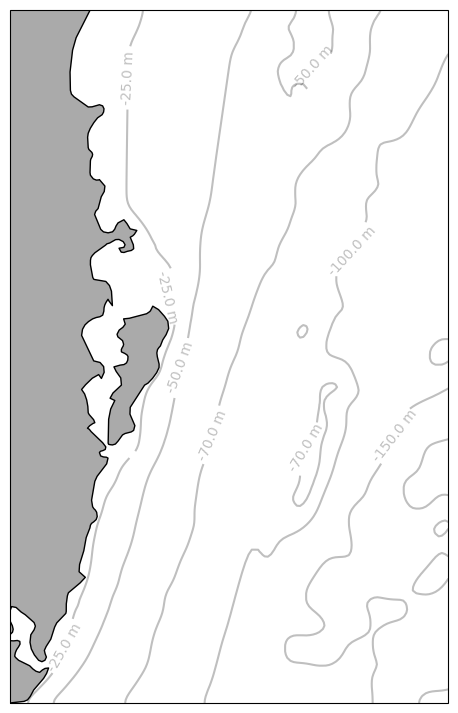

In [7]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.feature import NaturalEarthFeature

# from oceans.datasets import etopo_subset


# Bounding box with some spacing to spare.
dx = dy = 1.5

# Coastline
feature = NaturalEarthFeature(
    name="coastline",
    category="physical",
    scale="10m",
    edgecolor="#000000",
    facecolor="#AAAAAA",
)

# Bathymetry
levels = [-200, -150, -100, -70, -50, -25]

# Figure
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(
    figsize=(9, 9),
    subplot_kw={
        "projection": projection,
    },
)
ax.set_extent(bbox)
ax.add_feature(feature, zorder=0)


def fmt(x):
    s = f"{x:.1f}"
    return rf"{s} m"


cs = ax.contour(
    bathy["longitude"],
    bathy["latitude"],
    -bathy["depth"],
    levels=levels,
    colors="black",
    alpha=0.25,
    zorder=0,
    linestyles="-",
)
ax.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=10);

## Grid

In [8]:
import numpy as np

grid_spacing = 0.01
m = np.abs(np.diff(bathy["m"])[1:-1] - grid_spacing)
n = np.abs(np.diff(bathy["n"])[1:-1] - grid_spacing)

if np.allclose(m, 0.0, atol=1e-05) and np.allclose(n, 0.0, atol=1e-05):
    print(f"the grid spacing is {grid_spacing} degrees.")

the grid spacing is 0.01 degrees.


## Tides at Dados_Mare_Florencio2022

Essa parte é específica do modelo de máres apenas. Tudo acima se aplica a ambas rodadas de maré apenas e maré+vento.

In [9]:
import pandas as pd

df = pd.read_csv("Dados_Mare_Florencio2022.csv", index_col=0)
df

,Lon,Lat,M2,M2_fase,S2,S2_fase,O1,O1_fase,K1,K1_fase,N2,N2_fase,Q1,Q1_fase
ADCP_BaiaNorte,-48.5591,-27.5559,0.26,162.82,0.15,154.62,0.11,121.03,0.09,165.74,NaN,NaN,NaN,NaN
ADCP_BaiaSul,-48.5631,-27.5976,0.25,165.61,0.18,181.28,0.11,126.35,0.08,200.90,0.05,234.84,0.04,79.59
ACDP_Mocambique,-48.3896,-27.5267,0.19,148.12,0.13,135.02,0.03,91.06,0.06,161.89,0.03,219.91,0.03,91.06
Maregrafo_BaiaNorte,-48.4810,-27.4329,0.24,150.20,0.16,153.62,0.11,114.36,0.07,174.80,0.04,223.93,0.03,84.75
Maregrafo_BaiaSul,-48.5639,-27.8160,0.19,163.70,0.14,167.06,0.11,120.50,0.07,182.47,0.04,243.13,0.03,89.96


In [10]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


series = {}
for location, row in df.iterrows():
    m = find_nearest(ds["m"], row["Lon"])
    n = find_nearest(ds["n"], row["Lat"])
    serie = ds.isel(m=m, n=n)
    if np.isnan(serie["longitude"].to_numpy()):
        print(f"Skipping {location}.")
        continue
    series.update({location: serie})

Skipping ADCP_BaiaSul.
Skipping Maregrafo_BaiaSul.


In [11]:
import xoak

print(xoak.__version__)
# sklearn_geo_balltree would be better than scipy_kdtree but it doesn't accept NaNsseries
ds.xoak.set_index(["latitude", "longitude"], "scipy_kdtree")

0.1.1


In [12]:
for location, row in df.iterrows():
    if location in ["ADCP_BaiaSul", "Maregrafo_BaiaSul"]:
        point = xr.Dataset(
            {
                "longitude": ("point", [row["Lon"]]),
                "latitude": ("point", [row["Lat"]]),
            }
        )

        print(location)
        model_series = ds.xoak.sel(
            longitude=point["longitude"],
            latitude=point["latitude"],
        )
        series.update({location: model_series})

ADCP_BaiaSul
Maregrafo_BaiaSul


In [13]:
model_elev = {k: v["waterlevel"].to_numpy().squeeze() for k, v in series.items()}

model_elev = pd.DataFrame(model_elev)
model_elev.index = series["ACDP_Mocambique"]["time"].to_numpy()

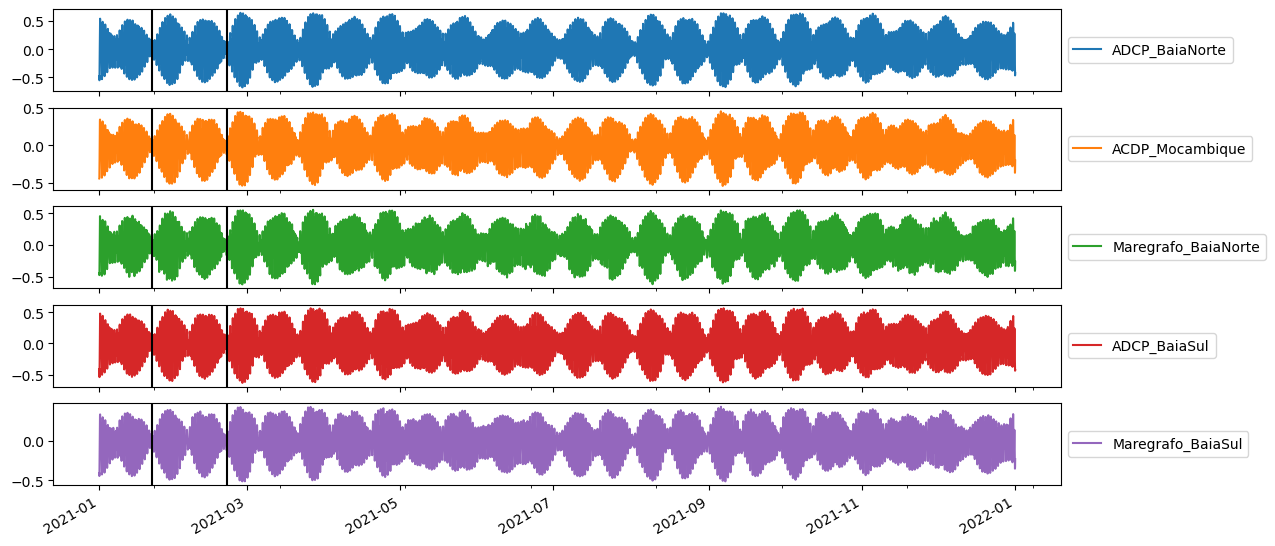

In [14]:
axes = model_elev.plot(subplots=True, legend=True, figsize=(13, 7))

start, end = "2021-01-22", "2021-02-21"

[ax.axvline(x=start, color="black") for ax in axes]
[ax.axvline(x=end, color="black") for ax in axes]
[ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5)) for ax in axes];

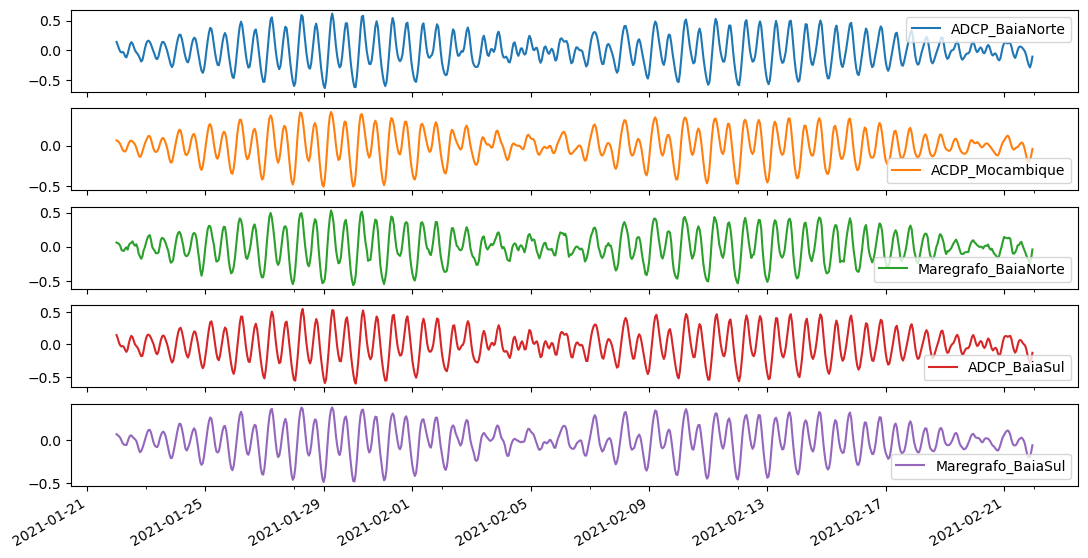

In [15]:
axes = model_elev[start:end].plot(subplots=True, legend=True, figsize=(13, 7))

## We can run the first experiments with this.

In [16]:
subset = ds.sel(time=slice(start, end))
subset

<xarray.Dataset>
Dimensions:     (m: 138, n: 218, time: 745)
Coordinates:
    Layer       float32 ...
    latitude    (m, n) float32 nan nan nan nan nan ... -26.49 -26.48 -26.47 nan
    longitude   (m, n) float32 nan nan nan nan nan ... -47.51 -47.51 -47.51 nan
  * m           (m) float32 -48.87 -48.87 -48.86 -48.85 ... -47.53 -47.52 -47.51
  * n           (n) float32 -28.62 -28.62 -28.61 -28.6 ... -26.48 -26.47 -26.47
  * time        (time) datetime64[ns] 2021-01-22 ... 2021-02-21T23:00:00.0000...
Data variables:
    velocity_x  (time, m, n) float32 ...
    velocity_y  (time, m, n) float32 ...
    waterlevel  (time, m, n) float32 ...
Attributes: (12/25)
    title:                         NetCDF created from NEFIS-file trim-sc_fl_...
    institution:                   
    source:                        Delft3D trim file
    history:                       Wed Mar 15 14:42:40 2023: ncks -4 -L 1 mod...
    references:                    http://svn.oss.deltares.nl
    email:                         
    ...                            ...
    geospatial_lon_units:          dergees_east
    geospatial_vertical_min:       2.2039968967437744
    geospatial_vertical_max:       547.0967407226562
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  down
    NCO:                           netCDF Operators version 5.1.5 (Homepage =...

In [17]:
# avg = subset.mean(dim="time")
avg = ds.mean(dim="time")
avg

<xarray.Dataset>
Dimensions:     (m: 138, n: 218)
Coordinates:
    Layer       float32 ...
    latitude    (m, n) float32 nan nan nan nan nan ... -26.49 -26.48 -26.47 nan
    longitude   (m, n) float32 nan nan nan nan nan ... -47.51 -47.51 -47.51 nan
  * m           (m) float32 -48.87 -48.87 -48.86 -48.85 ... -47.53 -47.52 -47.51
  * n           (n) float32 -28.62 -28.62 -28.61 -28.6 ... -26.48 -26.47 -26.47
Data variables:
    velocity_x  (m, n) float32 nan nan nan nan ... -0.002599 -0.02195 nan
    velocity_y  (m, n) float32 nan nan nan nan ... -5.199e-05 -6.864e-05 nan
    waterlevel  (m, n) float32 nan nan nan nan ... 3.457e-06 -8.401e-05 nan

In [18]:
def normalize_speed(u, v):
    u_norm = u / np.sqrt(u**2.0 + v**2.0)
    v_norm = v / np.sqrt(u**2.0 + v**2.0)
    speed = (u**2 + v**2) ** 0.5
    return (u_norm, v_norm, speed)


u = avg["velocity_x"].squeeze()
v = avg["velocity_y"].squeeze()
u_norm, v_norm, speed = normalize_speed(u, v)

In [19]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER


def creat_map(projection=ccrs.PlateCarree(), figsize=(9, 9), bbox=None):
    fig, ax = plt.subplots(
        figsize=figsize,
        subplot_kw={
            "projection": projection,
        },
    )
    if bbox:
        ax.set_extent(bbox)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.plot(-48.66, -26.89, "ro", label="Itajaí")
    ax.coastlines(resolution="10m")
    return fig, ax

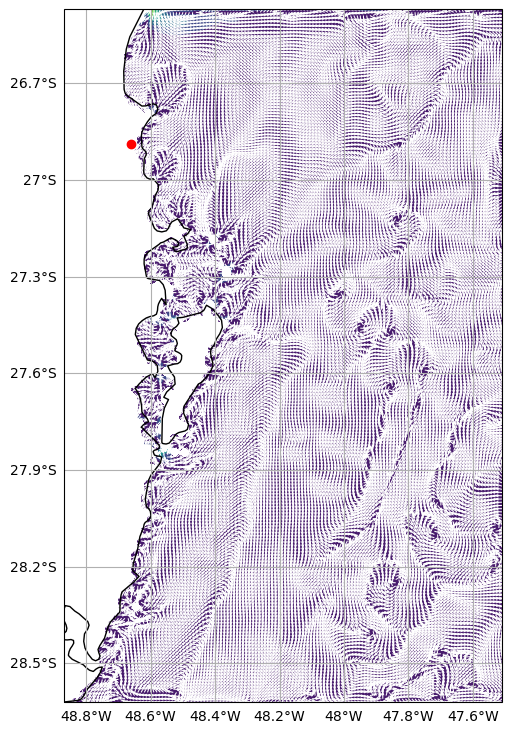

In [20]:
fig, ax = creat_map(bbox=bbox)
ax.contourf(avg["longitude"], avg["latitude"], speed)
ax.quiver(
    avg["longitude"],
    avg["latitude"],
    u_norm,
    v_norm,
    color="white",
    scale=50,
);

# TODO

O modelo com maré+vento é exatamente igual em grade, profundidade, tempo de simulação, barotrópico, etc.
Porém vale a pena criar cenários sazonais para a versão com vento.

- [ ] definir locais e lançamento
- [ ] definir tempo de simulação baseado em incerteza  da simulação
- [ ] 1 ou + ciclo(s) de maré, ou tudo, ou o mesmo período sazonal das simulações com vento?